# Project S Time Series Problem

## Time Series Analysis and Forecasting

In [1]:
! pip install statsmodels
! pip install fbprophet
! pip install xlrd
# If failed to install fbprophet, use conda install -c conda-forge fbprophet via anaconda.

  Using cached https://files.pythonhosted.org/packages/1a/b5/9c3fefa8a7b839729df57deedf0a69815841dfb88f0df911f34d998230b7/fbprophet-0.7.1.tar.gz
  Using cached https://files.pythonhosted.org/packages/e3/e2/204c9c6beaf9e05ad28bd589c154afff35dffa6166d76841d3c0dec6c1e3/cmdstanpy-0.9.5-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/66/ce/cacc6174b65d9e059725ccf8bb6b9653fb7174048a759de7fe639d9a7171/pystan-2.19.1.1-cp37-cp37m-macosx_10_6_intel.whl
     |████████████████████████████████| 10.0MB 9.3MB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/ab/e0/a52ffc02395474858552ca6437226e23ad67e25fd85cb387f02e479cfe01/LunarCalendar-0.0.9-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ca/7b/ba752f4383dd775de1fa825d4a3bf1df4109be9a1986c905232c83373615/convertdate-2.3.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d9/c7/1d0cb8f69bb4caa252a0c95de66a34e0548cbf9d3f4a2353cba5ee5f566c/holidays-0.10.3.tar.g

  Created wheel for holidays: filename=holidays-0.10.3-cp37-none-any.whl size=115857 sha256=758cb675eca6c35ffb696b5d05e442c4ed67dd73271fe6639eea527bb7c1a50b
  Stored in directory: /Users/schweini/Library/Caches/pip/wheels/d3/a6/3c/4072c36c7d443be579c0917845e1b27fc1f09d4867c41e170d
  Created wheel for pymeeus: filename=PyMeeus-0.3.7-cp37-none-any.whl size=702877 sha256=eb110756f48a2097e73606a262ce47c3e0756150cf8d127b96e9cf94c94ba63e
  Stored in directory: /Users/schweini/Library/Caches/pip/wheels/8d/1a/e7/684cd77a99aac294f976db834fe613b5424f7c4d75ffb0b84d
Successfully built holidays pymeeus
Failed to build fbprophet
  Found existing installation: pandas 0.25.1
    Uninstalling pandas-0.25.1:
      Successfully uninstalled pandas-0.25.1
^C


In [2]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import matplotlib
from fbprophet import Prophet

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

warnings.filterwarnings("ignore")

Importing plotly failed. Interactive plots will not work.


### Get data and preprocessing

In [3]:
df = pd.read_excel("Sales_data.xls")
furniture = df.loc[df['Category'] == 'Furniture']
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

In [4]:
# We will only get the columns of Order Date and Sales of Furniture
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [5]:
# This shows when furniture is sold
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

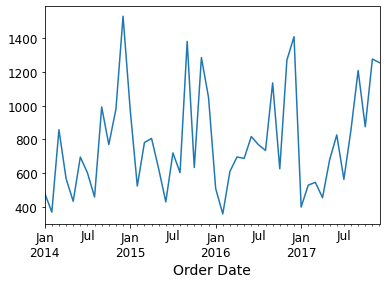

In [6]:
# We will deal with the probelm with Monthly Sale
# This graph shows that furniture sales have periodicity
y = furniture['Sales'].resample('MS').mean()
y.plot()
plt.show()

### (a) Time series forecasting

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.
How could we predict future data? We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

In [7]:
# p, d, q are account for seasonality, trend, and noise
p = d = q = range(0, 2)
# For grid search, we need to generate (0,0,0), (0,0,1) ... combinations
# Generate two pair of combination list, one is (0,0,0) and the other is form of (0,0,0,12)
# Start code
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
# End code

In [8]:
# grid search to find the optimal set of parameters that yields the best performance for our model.
pair = {}
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            pair[str(param) + 'x' + str(param_seasonal)] = results.aic
        except:
            continue
print(min(pair, key=pair.get))

(0, 1, 1)x(0, 1, 1, 12)


In [9]:
# Fit model with optimal set of parameters
# Fill the blank with optimal set got above
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1), # This value need to be blank
                                seasonal_order=(1, 1, 0, 12), # This value need to be blank
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


##### Observation of the model diagnostics
:

### (b) MSE of forecasted data

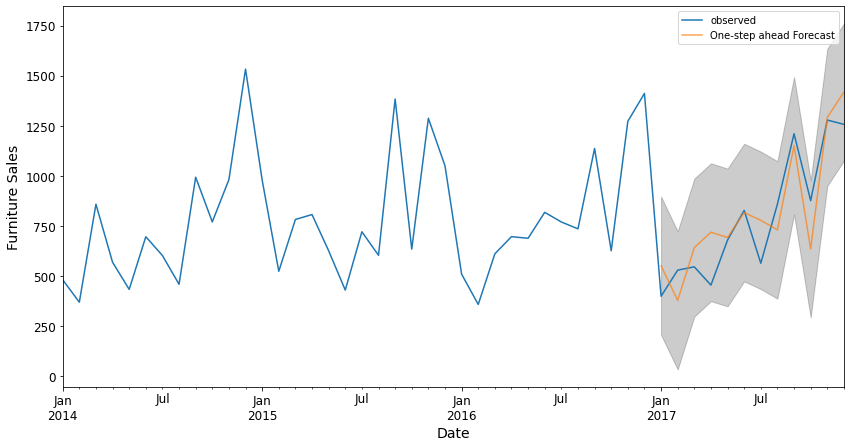

In [10]:
# Prediction will be based on the data from 2014~2017 and will predict data after 2017
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [11]:
# Now let's check the MSE and RMSE of prediction

# Start code
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
# End of the code

print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 22993.56
The Root Mean Squared Error of our forecasts is 151.64


##### Observation of the RMSE. Is it useful?
:

 ### (c) Time series of two different data : comparison

From (a), (b), we forecasted sales of furniture based on the past data. In this section we will do the same thing for the another sales data and decide which one will be more productive in the future. Our target is office supplies from the same dataset. Here, we will use Prophet package developed by Facebook in 2017. https://facebook.github.io/prophet/

### Get data and preprocessing

In [12]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']

In [13]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')
y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()
furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})
store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


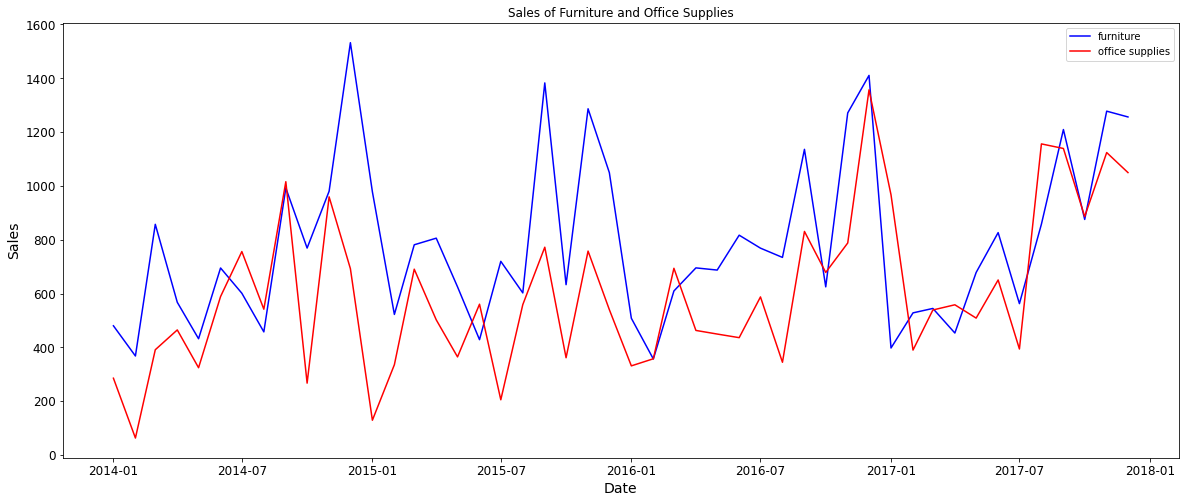

In [14]:
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Furniture and Office Supplies')
plt.legend();

##### Observation of sales of Furniture and Office supplies
:

### Predict funiture, Office supplies Sales

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1296x432 with 0 Axes>

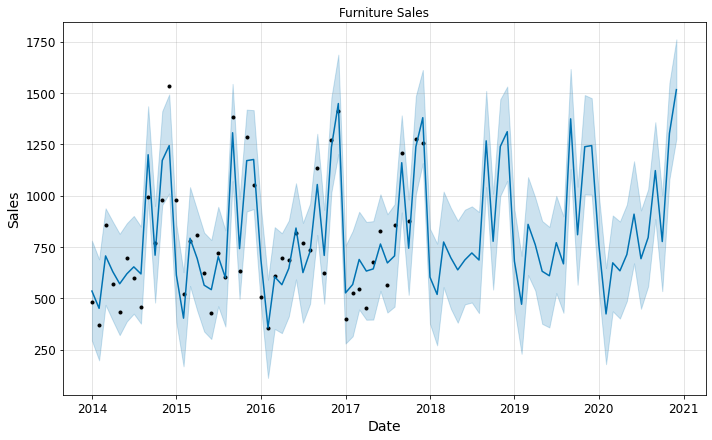

In [15]:
furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)
office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)
furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)
office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');

In [16]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]
merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()
merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names
forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'office_ds')
forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()

,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,...,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2014-01-01,726.057713,293.851108,780.610970,726.057713,726.057713,-190.685662,-190.685662,-190.685662,-190.685662,...,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,0.0,0.0,0.0,347.490278
1,2014-02-01,727.494023,198.055757,690.023551,727.494023,727.494023,-276.377703,-276.377703,-276.377703,-276.377703,...,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,0.0,0.0,0.0,109.240162
2,2014-03-01,728.791335,467.952797,938.205085,728.791335,728.791335,-22.389755,-22.389755,-22.389755,-22.389755,...,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,0.0,0.0,0.0,470.211349
3,2014-04-01,730.227645,391.662570,873.697478,730.227645,730.227645,-100.141158,-100.141158,-100.141158,-100.141158,...,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,0.0,0.0,0.0,374.687188
4,2014-05-01,731.617622,320.804727,813.963976,731.617622,731.617622,-160.815662,-160.815662,-160.815662,-160.815662,...,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,0.0,0.0,0.0,252.306682


In [17]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]
merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()
merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names
forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'office_ds')
forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()

,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,...,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2014-01-01,726.057713,293.851108,780.610970,726.057713,726.057713,-190.685662,-190.685662,-190.685662,-190.685662,...,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,0.0,0.0,0.0,347.490278
1,2014-02-01,727.494023,198.055757,690.023551,727.494023,727.494023,-276.377703,-276.377703,-276.377703,-276.377703,...,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,0.0,0.0,0.0,109.240162
2,2014-03-01,728.791335,467.952797,938.205085,728.791335,728.791335,-22.389755,-22.389755,-22.389755,-22.389755,...,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,0.0,0.0,0.0,470.211349
3,2014-04-01,730.227645,391.662570,873.697478,730.227645,730.227645,-100.141158,-100.141158,-100.141158,-100.141158,...,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,0.0,0.0,0.0,374.687188
4,2014-05-01,731.617622,320.804727,813.963976,731.617622,731.617622,-160.815662,-160.815662,-160.815662,-160.815662,...,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,0.0,0.0,0.0,252.306682


##### When will the office supplies exceed furniture?
: